In [1]:
import sys
!{sys.executable} -m pip install python-dotenv boto3 Pillow matplotlib
!{sys.executable} -m pip install fastapi uvicorn pydantic Pillow python-multipart
!{sys.executable} -m pip install tensorflow


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
Using cached python_multipart-0.0.20-py3-none-any.whl (24 kB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


Total images loaded: 20654
Total labels loaded: 20654
Total unique classes: 16

Sample image paths and labels:
1: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\Pepper__bell___Bacterial_spot\0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG --> Pepper__bell___Bacterial_spot
2: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\Pepper__bell___Bacterial_spot\006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG --> Pepper__bell___Bacterial_spot
3: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\Pepper__bell___Bacterial_spot\00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG --> Pepper__bell___Bacterial_spot
4: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\Pepper__bell___Bacterial_spot\01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG --> Pepper__bell___Bacterial_spot
5: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\Pepper__bell___Bacterial_spot\0169b9ac-07b9-4be1-8b85-da94481f05a4___NREC_B.Spot 9169.JPG --> Pepper__bell___Ba

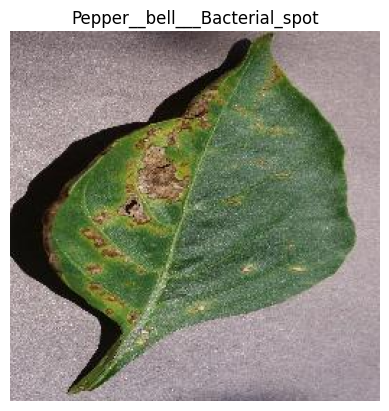

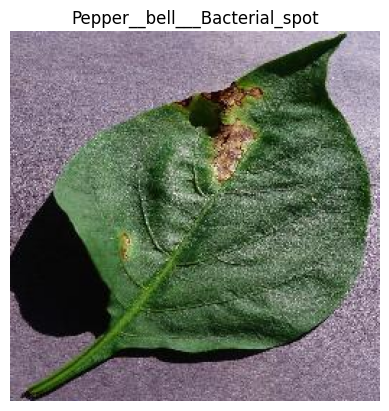

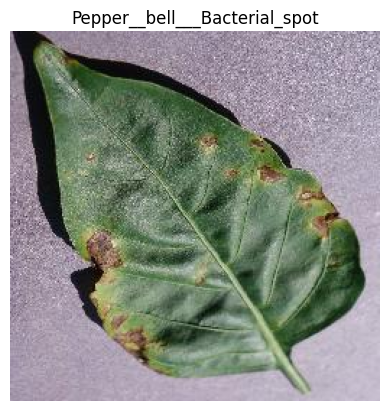

In [ ]:
import os
import tempfile
from dotenv import load_dotenv
import boto3
from PIL import Image
import matplotlib.pyplot as plt

load_dotenv()  

AWS_ACCESS_KEY_ID     = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION            = os.getenv("AWS_REGION", "us-east-1")
BUCKET_NAME           = os.getenv("AWS_S3_BUCKET")

if not all([AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, BUCKET_NAME]):
    raise RuntimeError("Set AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_REGION, and AWS_S3_BUCKET in your .env")

s3     = boto3.resource(
    "s3",
    region_name=AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)
bucket = s3.Bucket(BUCKET_NAME)

tmpdir = tempfile.mkdtemp(prefix="s3-mirror-")
print(f"Downloading entire bucket → {tmpdir}")

for obj in bucket.objects.all():
    # skip “folders”
    if obj.key.endswith("/"):
        continue
    target_path = os.path.join(tmpdir, obj.key)   
    os.makedirs(os.path.dirname(target_path), exist_ok=True)
    bucket.download_file(obj.key, target_path)

print("✅ All files downloaded from S3.")

dataset_path = tmpdir

# 2. Initialize storage lists
data = []
labels = []

# 3. Loop through each class folder and collect image paths and labels
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Just to be safe — ignore non-folder files
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append(img_path)
            labels.append(class_name)

# 4. Check how many images and labels were loaded
print(f"Total images loaded: {len(data)}")
print(f"Total labels loaded: {len(labels)}")
print(f"Total unique classes: {len(set(labels))}")

# 5. Print a few sample paths and labels
print("\nSample image paths and labels:")
for i in range(5):
    print(f"{i+1}: {data[i]} --> {labels[i]}")

# 6. Display a few sample images
print("\nDisplaying sample images:")
for i in range(3):
    img = Image.open(data[i])
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')
    plt.show()


In [11]:
import pandas as pd

df = pd.DataFrame({
    'image_path': data,
    'label': labels
})

# Quick check
print(df.head())
print(f"\nTotal samples in DataFrame: {len(df)}")

                                          image_path  \
0  E:/NCI/ProgrammingforAI/Project/Dataset-1/Plan...   
1  E:/NCI/ProgrammingforAI/Project/Dataset-1/Plan...   
2  E:/NCI/ProgrammingforAI/Project/Dataset-1/Plan...   
3  E:/NCI/ProgrammingforAI/Project/Dataset-1/Plan...   
4  E:/NCI/ProgrammingforAI/Project/Dataset-1/Plan...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  

Total samples in DataFrame: 20654


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Optional: see the mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Map:")
print(label_map)


Label Encoding Map:
{'Pepper__bell___Bacterial_spot': np.int64(0), 'Pepper__bell___healthy': np.int64(1), 'PlantVillage': np.int64(2), 'Potato___Early_blight': np.int64(3), 'Potato___Late_blight': np.int64(4), 'Potato___healthy': np.int64(5), 'Tomato_Bacterial_spot': np.int64(6), 'Tomato_Early_blight': np.int64(7), 'Tomato_Late_blight': np.int64(8), 'Tomato_Leaf_Mold': np.int64(9), 'Tomato_Septoria_leaf_spot': np.int64(10), 'Tomato_Spider_mites_Two_spotted_spider_mite': np.int64(11), 'Tomato__Target_Spot': np.int64(12), 'Tomato__Tomato_YellowLeaf__Curl_Virus': np.int64(13), 'Tomato__Tomato_mosaic_virus': np.int64(14), 'Tomato_healthy': np.int64(15)}


In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

def preprocess_image(path, target_size=(256,256)):
    """
    Loads an image from disk, resizes to target_size, 
    scales pixels to [0,1], and returns a float32 array.
    """
    # normalize path separators
    path = os.path.normpath(path)
    img = keras_image.load_img(path, target_size=target_size)
    arr = keras_image.img_to_array(img) / 255.0
    return arr


In [14]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

def is_valid_image_file(path):
    # Ensure it's a file and has a proper image extension
    return os.path.isfile(path) and path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))

def preprocess_image(path, target_size=(128, 128)):
    """
    Loads an image from disk, resizes to target_size, 
    scales pixels to [0,1], and returns a float32 array.
    """
    # normalize path separators
    path = os.path.normpath(path)
    img = keras_image.load_img(path, target_size=target_size)
    arr = keras_image.img_to_array(img).astype(np.float16) / 255.0  # use float16 to reduce memory usage
    return arr

X = []
y = []

# Optional: limit number of images to avoid memory error
MAX_IMAGES = 5000  # Set to None to load all

count = 0
for path, label in zip(df['image_path'], df['label_encoded']):
    if MAX_IMAGES and count >= MAX_IMAGES:
        break
    if is_valid_image_file(path):
        try:
            img = preprocess_image(path)
            X.append(img)
            y.append(label)
            count += 1
        except Exception as e:
            print(f"❌ Error loading image: {path} -> {e}")
    else:
        print(f"⚠️ Skipping invalid or hidden file: {path}")

X = np.array(X)
y = np.array(y)

print(f"\n✅ Processed {len(X)} images.")
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")


⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Pepper__bell___Bacterial_spot
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Pepper__bell___healthy
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Potato___Early_blight
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Potato___healthy
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Potato___Late_blight
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Tomato_Bacterial_spot
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Tomato_Early_blight
⚠️ Skipping invalid or hidden file: E:/NCI/ProgrammingforAI/Project/Dataset-1/PlantVillage\PlantVillage\Tomato_health

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")


X_train: (4000, 128, 128, 3), y_train: (4000,)
X_val:   (1000, 128, 128, 3),   y_val:   (1000,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixels
    validation_split=0.2   # split off 20% for validation
)

train_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 33027 images belonging to 16 classes.
Found 8249 images belonging to 16 classes.


In [17]:
from tensorflow.keras import layers, models, Input

num_classes = train_generator.num_classes  

model = models.Sequential([
    Input(shape=(128, 128, 3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,879,184 (64.39 MB)

 Trainable params: 16,879,184 (64.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


In [ ]:
# Save model after training on the original dataset
model.save("plant_disease_model.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the pretrained model
model = load_model("./plant_disease_model.h5")


In [19]:
for layer in model.layers[:-2]:  # freeze all except last conv and dense
    layer.trainable = False


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

load_dotenv()

AWS_ACCESS_KEY_ID     = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION            = os.getenv("AWS_REGION", "us-east-1")
NEW_BUCKET            = os.getenv("AWS_S3_NEW_BUCKET")
NEW_PREFIX            = os.getenv("AWS_S3_NEW_PREFIX", "")

if not all([AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, NEW_BUCKET, NEW_PREFIX]):
    raise RuntimeError("Make sure AWS creds, AWS_S3_NEW_BUCKET and AWS_S3_NEW_PREFIX are set in your .env")

s3    = boto3.resource(
    "s3",
    region_name=AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)
bucket = s3.Bucket(NEW_BUCKET)

tmpdir = tempfile.mkdtemp(prefix="s3-augmented-")
print(f"Downloading s3://{NEW_BUCKET}/{NEW_PREFIX} → {tmpdir}")

for obj in bucket.objects.filter(Prefix=NEW_PREFIX):
    if obj.key.endswith("/"):
        continue
    rel_path    = os.path.relpath(obj.key, NEW_PREFIX)
    target_path = os.path.join(tmpdir, rel_path)
    os.makedirs(os.path.dirname(target_path), exist_ok=True)
    bucket.download_file(obj.key, target_path)

print("✅ Augmented dataset downloaded.")

new_dataset_path = tmpdir

new_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

new_train_gen = new_datagen.flow_from_directory(
    directory=new_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

new_val_gen = new_datagen.flow_from_directory(
    directory=new_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


In [ ]:
# Update the last dense layer to match the new number of classes
from tensorflow.keras import layers, models

# Optionally build a new model based on old one
base_model = model

# You can remove the last layer if number of classes differs
new_model = models.Sequential(base_model.layers[:-1])  # remove final Dense
new_model.add(layers.Dense(new_train_gen.num_classes, activation='softmax'))

# Compile again
new_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = new_model.fit(
    new_train_gen,
    validation_data=new_val_gen,
    epochs=10
)

model.save('plant_disease_model_augmented.h5')

# Model Metrics

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


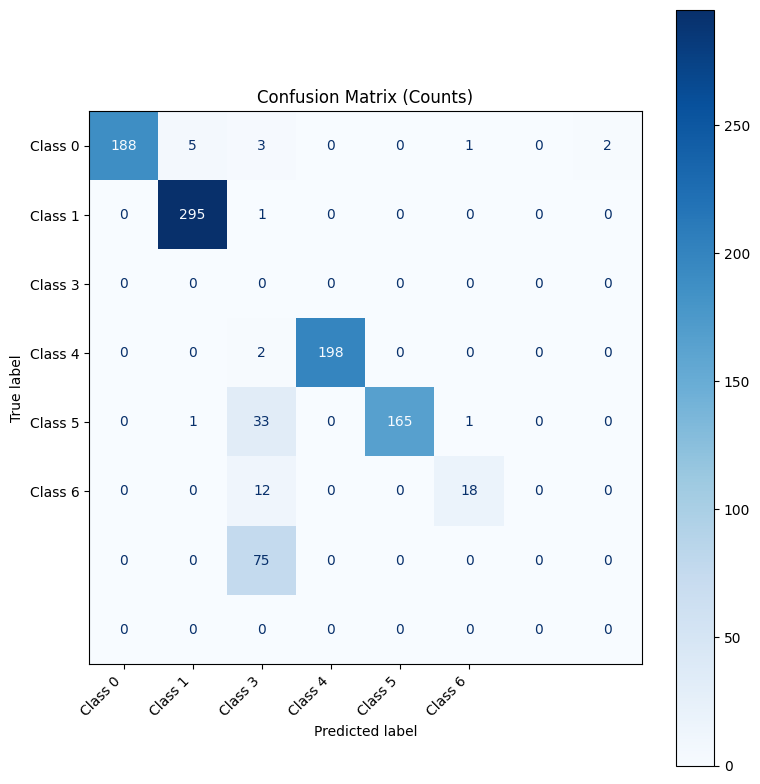

Accuracy:      0.8640

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       199
           1       0.98      1.00      0.99       296
           2       0.00      0.00      0.00         0
           3       1.00      0.99      0.99       200
           4       1.00      0.82      0.90       200
           5       0.90      0.60      0.72        30
           6       0.00      0.00      0.00        75
          10       0.00      0.00      0.00         0

    accuracy                           0.86      1000
   macro avg       0.61      0.54      0.57      1000
weighted avg       0.92      0.86      0.89      1000


Multi-class ROC AUC (OVR): 0.9996


c:\Users\nandu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

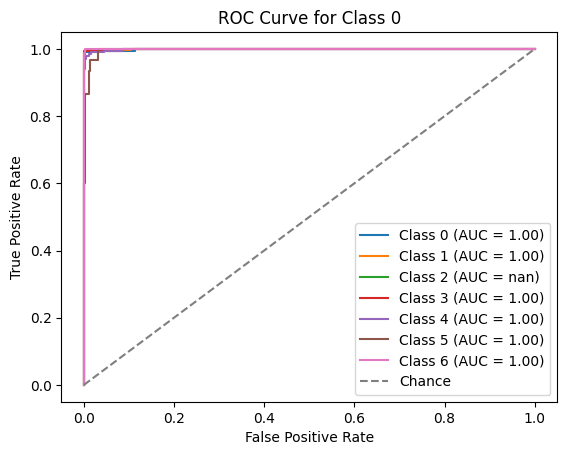

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# LOAD MODEL
model = load_model(r"./plant_disease_model_augmented.h5")

x_test, y_test = X_val, y_val               

y_pred_prob = model.predict(x_test)         
y_pred      = np.argmax(y_pred_prob, axis=1)
y_true      = y_test

conf_mat = confusion_matrix(y_true, y_pred)

# CONFUSION MATRIX
class_labels = np.unique(y_true)
class_names  = [f"Class {int(lbl)}" for lbl in class_labels]
n_classes    = len(class_names)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
try:
    disp.plot(ax=ax, values_format="d", cmap=plt.cm.Blues)
except ValueError:
    pass
ax.set(
    xticks=np.arange(n_classes),
    xticklabels=class_names,
    yticks=np.arange(n_classes),
    yticklabels=class_names,
    xlabel="Predicted label",
    ylabel="True label"
)
plt.xticks(rotation=45, ha="right")
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

#  METRICS 
acc      = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
clf_rep  = classification_report(y_true, y_pred)
print(f"Accuracy:      {acc:.4f}")
print("\nClassification Report:")
print(clf_rep)

# ROC Curve
n_classes   = y_pred_prob.shape[1]
y_true_bin  = label_binarize(y_true, classes=range(n_classes))

# only include the classes actually in y_true
labels      = np.unique(y_true)
y_score_sub = y_pred_prob[:, labels]
y_score_sub = y_score_sub / np.sum(y_score_sub, axis=1, keepdims=True)

roc_auc     = roc_auc_score(
    y_true,
    y_score_sub,
    multi_class='ovr',
    labels=labels
)
print(f"\nMulti-class ROC AUC (OVR): {roc_auc:.4f}")

for i in range(7):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')


# fpr, tpr, _ = roc_curve(y_true_bin[:,0], y_pred_prob[:,0])
# plt.figure(figsize=(8,8))
# plt.plot(fpr, tpr, label=f'Class 0 (AUC = {roc_auc_score(y_true_bin[:,0], y_pred_prob[:,0]):.2f})')
plt.plot([0,1],[0,1],'--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all classes')
plt.legend(loc='lower right')
plt.show()



# Severity Estimation and Treatment Recommendations

In [1]:
# Severity based on classifier confidence
def estimate_severity(confidence, thresholds=(0.6, 0.85)):
    if confidence < thresholds[0]:
        return 'mild'
    elif confidence < thresholds[1]:
        return 'moderate'
    else:
        return 'severe'

treatment_guidelines = {
    "Apple__Scab": {
        "mild": [
            "Remove and destroy fallen leaves and mummified fruit.",
            "Apply a single copper spray at first sign of spots.",
        ],
        "moderate": [
            "Repeat fungicide (e.g. captan or mancozeb) every 10–14 days.",
            "Prune for better air circulation."
        ],
        "severe": [
            "Switch to resistant scab‐resistant cultivars next season.",
            "Rogue out heavily infected trees; consider soil sanitation."
        ],
    },
    "Apple__Black_rot": {
        "mild": [
            "Sanitize pruners; remove any small rotted spots.",
            "Apply protective fungicide (eg. chlorothalonil) once."
        ],
        "moderate": [
            "Spray fungicide every 7–10 days for 3–4 applications.",
            "Prune and remove cankered branches."
        ],
        "severe": [
            "Destroy mummified fruit and severe cankers immediately.",
            "Rotate orchards or replant in clean soil if outbreak persists."
        ],
    },
    "Apple__Cedar_rust": {
        "mild": [
            "Remove nearby juniper hosts if possible.",
            "Apply copper spray once at early leaf‐unfolding."
        ],
        "moderate": [
            "Spray fungicide (e.g. myclobutanil) every 14 days.",
            "Prune infected shoots and destroy."
        ],
        "severe": [
            "Space plantings to improve airflow.",
            "Use resistant apple cultivars next season."
        ],
    },
    "Apple__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Cherry__Powdery_mildew": {
        "mild": [
            "Remove affected leaves and destroy.",
            "Apply a single sulfur dust or spray."
        ],
        "moderate": [
            "Repeat sulfur or potassium bicarbonate spray every 7–10 days.",
            "Ensure good air circulation through pruning."
        ],
        "severe": [
            "Use systemic fungicide (e.g. tebuconazole) on a 10‐day schedule.",
            "Consider resistant rootstocks/cultivars."
        ],
    },
    "Cherry__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Corn__Gray_leaf_spot": {
        "mild": [
            "Remove volunteer corn and debris.",
            "Apply a protectant fungicide (e.g. azoxystrobin) once."
        ],
        "moderate": [
            "Spray fungicide every 14 days if conditions are wet.",
            "Rotate with non‐grass crops."
        ],
        "severe": [
            "Plant resistant hybrids next season.",
            "Deep‐till residue to hasten decomposition."
        ],
    },
    "Corn__Common_rust": {
        "mild": [
            "Monitor; rust often resolves in dry weather.",
            "No treatment if lesions <5% leaf area."
        ],
        "moderate": [
            "Apply systemic fungicide (e.g. pyraclostrobin) once.",
            "Avoid overhead irrigation."
        ],
        "severe": [
            "Repeat fungicide after 14 days if needed.",
            "Use rust‐resistant hybrids next year."
        ],
    },
    "Corn__Northern_leaf_blight": {
        "mild": [
            "Improve field drainage.",
            "Apply protective fungicide once."
        ],
        "moderate": [
            "Spray fungicide (e.g. chlorothalonil) every 10–14 days.",
            "Rotate crops out of maize."
        ],
        "severe": [
            "Use broad‐spectrum systemic fungicides in rotation.",
            "Select resistant hybrids for next planting."
        ],
    },
    "Corn__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Grape__Black_rot": {
        "mild": [
            "Remove mummified berries and leaves.",
            "Apply single protective spray (e.g. mancozeb)."
        ],
        "moderate": [
            "Spray fungicide every 10 days during wet weather.",
            "Improve canopy ventilation via pruning."
        ],
        "severe": [
            "Use systemic fungicides in rotation.",
            "Switch to resistant varieties next season."
        ],
    },
    "Grape__Black_measles": {
        "mild": [
            "Cull small infected clusters.",
            "Apply protective sprays once."
        ],
        "moderate": [
            "Repeat fungicide every 14 days.",
            "Remove nearby volunteer vines."
        ],
        "severe": [
            "Use systemic fungicides labeled for Phomopsis.",
            "Remove debris and disinfect tools."
        ],
    },
    "Grape__Leaf_blight": {
        "mild": [
            "Remove and destroy spotted leaves.",
            "Apply protectant fungicide once."
        ],
        "moderate": [
            "Spray fungicide every 10 days.",
            "Thin canopy to reduce humidity."
        ],
        "severe": [
            "Rotate fungicide modes of action.",
            "Consider replacing blocks with resistant stocks."
        ],
    },
    "Grape__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Orange__Huanglongbing": {
        "mild": [
            "Prune out individual symptomatic shoots.",
            "Apply insecticide once to control psyllid vector."
        ],
        "moderate": [
            "Spray systemic insecticide every 30 days.",
            "Use disease‐free nursery stock."
        ],
        "severe": [
            "Remove and destroy severely infected trees.",
            "Implement area‐wide vector control."
        ],
    },
    "Orange__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Peach__Bacterial_spot": {
        "mild": [
            "Remove minor lesions with pruning shears.",
            "Apply copper spray once at bud‐break."
        ],
        "moderate": [
            "Repeat copper applications every 14 days.",
            "Sanitize tools between cuts."
        ],
        "severe": [
            "Destroy heavily infected shoots.",
            "Switch to resistant rootstocks next season."
        ],
    },
    "Peach__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Pepper__bell___Bacterial_spot": {
        "mild": [
            "Remove any spotted leaves and destroy them.",
            "Apply a copper‐based bactericide once.",
            "Avoid overhead irrigation to reduce splash."
        ],
        "moderate": [
            "Prune out heavily infected foliage.",
            "Apply copper sprays every 7–10 days.",
            "Rotate with non‐host crops next season."
        ],
        "severe": [
            "Remove and destroy entire plants if >50% foliage is infected.",
            "Use certified disease‐free seed next season.",
            "Consider soil fumigation if problem persists."
        ],
    },
    "Pepper__bell___healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Potato__Early_blight": {
        "mild": [
            "Remove lower, infected leaves.",
            "Apply a protectant fungicide (e.g., chlorothalonil) once."
        ],
        "moderate": [
            "Spray fungicide every 7 days for 2–3 applications.",
            "Remove volunteer potatoes from field margins."
        ],
        "severe": [
            "Use a systemic fungicide (e.g., mancozeb) on a 7‐day interval.",
            "Destroy cull piles to prevent overwintering."
        ],
    },
    "Potato__Late_blight": {
        "mild": [
            "Apply copper‐based fungicide at first sign of lesions.",
            "Improve drainage to reduce leaf wetness."
        ],
        "moderate": [
            "Alternate copper with a systemic fungicide every 5–7 days.",
            "Rogue out small patches of infected plants."
        ],
        "severe": [
            "Destroy heavily infected plants immediately.",
            "Switch to resistant varieties next season."
        ],
    },
    "Potato___healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Squash__Powdery_mildew": {
        "mild": [
            "Prune lightly infected leaves.",
            "Apply sulfur or potassium bicarbonate once."
        ],
        "moderate": [
            "Spray fungicide every 7–10 days.",
            "Increase plant spacing to improve airflow."
        ],
        "severe": [
            "Use systemic fungicide labeled for cucurbits.",
            "Rotate out of squash family next year."
        ],
    },
    "Squash__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Strawberry__Leaf_scorch": {
        "mild": [
            "Remove a few scorched leaflets.",
            "Apply a single copper fungicide spray."
        ],
        "moderate": [
            "Spray fungicide every 10–14 days.",
            "Avoid overhead watering."
        ],
        "severe": [
            "Rotate planting location away from strawberries.",
            "Use disease‐free runners next season."
        ],
    },
    "Strawberry__healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    },

    "Tomato_Bacterial_spot": {
        "mild": [
            "Remove and destroy spotted leaves.",
            "Apply copper spray once."
        ],
        "moderate": [
            "Repeat copper applications every 7–10 days.",
            "Avoid working in wet foliage to limit spread."
        ],
        "severe": [
            "Use bactericide rotations (copper + mancozeb).",
            "Plant resistant cultivars next season."
        ],
    },
    "Tomato_Early_blight": {
        "mild": [
            "Prune off lower foliage.",
            "Apply mancozeb once."
        ],
        "moderate": [
            "Spray fungicide every week for 3 weeks.",
            "Mulch to reduce soil splash."
        ],
        "severe": [
            "Use systemic fungicide programs.",
            "Rotate crops out of Solanaceae family."
        ],
    },
    "Tomato_Late_blight": {
        "mild": [
            "Copper fungicide at first symptom.",
            "Improve canopy ventilation."
        ],
        "moderate": [
            "Alternate copper with a systemic fungicide every 5–7 days.",
            "Remove volunteer nightshades nearby."
        ],
        "severe": [
            "Destroy infected plants immediately.",
            "Use certified seed and resistant varieties."
        ],
    },
    "Tomato_Leaf_Mold": {
        "mild": [
            "Increase airflow by pruning.",
            "Apply copper spray once."
        ],
        "moderate": [
            "Spray chlorothalonil every 10 days.",
            "Reduce nighttime humidity if possible."
        ],
        "severe": [
            "Use systemic fungicide labeled for leaf mold.",
            "Disinfect greenhouse surfaces."
        ],
    },
    "Tomato_Septoria_leaf_spot": {
        "mild": [
            "Remove lower infected leaves.",
            "Apply a protectant fungicide once."
        ],
        "moderate": [
            "Apply fungicide every 7–10 days.",
            "Rotate crops away from tomatoes for 2 years."
        ],
        "severe": [
            "Use systemic fungicides in rotation.",
            "Remove and destroy all plant debris."
        ],
    },
    "Tomato_Spider_mites_Two_spotted_sp": {
        "mild": [
            "Spray plants with a strong jet of water to knock off mites.",
            "Increase humidity around plants."
        ],
        "moderate": [
            "Apply insecticidal soap or neem oil every 7 days.",
            "Remove heavily infested leaves."
        ],
        "severe": [
            "Rotate miticides with different modes of action.",
            "Introduce predatory mites as biological control."
        ],
    },
    "Tomato__Target_Spot": {
        "mild": [
            "Remove leaf spots as they appear.",
            "Apply protectant fungicide once."
        ],
        "moderate": [
            "Spray chlorothalonil every 10 days.",
            "Maintain good field sanitation."
        ],
        "severe": [
            "Use systemic fungicides in rotation.",
            "Consider resistant cultivars next season."
        ],
    },
    "Tomato__Tomato_YellowLeaf__Curl_Vir": {
        "mild": [
            "Remove whiteflies by vacuum or sticky traps.",
            "Use reflective mulch to deter vectors."
        ],
        "moderate": [
            "Apply insecticide targeting whiteflies every 7 days.",
            "Rogue out infected plants immediately."
        ],
        "severe": [
            "Plant resistant varieties.",
            "Implement glasshouse or exclusion netting if feasible."
        ],
    },
    "Tomato__Tomato_mosaic_virus": {
        "mild": [
            "Sanitize tools and hands between plants.",
            "Rogue out a few infected plants."
        ],
        "moderate": [
            "Remove all infected plants from the field.",
            "Use certified virus‑free seed."
        ],
        "severe": [
            "Destroy crop debris thoroughly.",
            "Rotate out of tomatoes for at least 2 seasons."
        ],
    },
    "Tomato_healthy": {
        "mild":   ["Plant appears healthy; no treatment needed."],
        "moderate":["Plant appears healthy; no treatment needed."],
        "severe": ["Plant appears healthy; no treatment needed."]
    }
}

# Takes all treatment guidlines keys and makes a list for them
class_names = list(treatment_guidelines.keys())
# Creates a new dictionary whose keys are the integer indices based on the class_name list
inv_class_indices = {i: class_names[i] for i in range(len(class_names))}

In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model
model = load_model("./plant_disease_model_augmented.h5")


# The diagnose‐and‐treat function
def diagnose_and_treat(img_path, model, class_map, treatments, thresholds=(0.6,0.85)):
    img = keras_image.load_img(img_path, target_size=(128,128))
    x   = keras_image.img_to_array(img) / 255.0
    x_b = np.expand_dims(x, 0)
    preds = model.predict(x_b)
    idx   = int(np.argmax(preds, axis=1)[0])
    conf  = float(preds[0, idx])
    disease = class_map[idx]
    severity = estimate_severity(conf, thresholds)
    steps    = treatments.get(disease, {}).get(
                   severity,
                   ["No guideline available. Consult an expert."]
               )
    return {
        "disease": disease,
        "confidence": conf,
        "severity": severity,
        "treatment_steps": steps
    }

img_path = r"./Pepper__bell___Bacterial_spot/0b27c03f-b3bc-4d96-9b76-6fbd779404b9___NREC_B.Spot 1799.JPG"
report = diagnose_and_treat(img_path, model, inv_class_indices, treatment_guidelines)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'disease': 'Apple__Scab', 'confidence': 0.9993537068367004, 'severity': 'severe', 'treatment_steps': ['Switch to resistant scab‐resistant cultivars next season.', 'Rogue out heavily infected trees; consider soil sanitation.']}


# For connecting to UI

In [ ]:
# 1️⃣ Apply nest_asyncio first
import nest_asyncio
nest_asyncio.apply()

# 2️⃣ Imports
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse
from pydantic import BaseModel
from typing import List
import io, os
from PIL import Image
from tensorflow.keras.models import load_model
import uvicorn

# 3️⃣ Load model
model = load_model("./plant_disease_model_augmented.h5")

# 4️⃣ Dummy placeholders (replace with your real logic)
inv_class_indices = {"0": "Healthy", "1": "Diseased"}
treatment_guidelines = {
    "Healthy": ["No action needed"],
    "Diseased": ["Remove affected leaves", "Apply fungicide"]
}

def diagnose_and_treat(image_path, model, class_indices, guidelines):
    # Your real prediction logic here
    # Dummy example:
    pred_class = "Diseased"
    confidence = 0.87
    return {
        "disease": pred_class,
        "confidence": confidence,
        "severity": "Moderate",
        "treatment_steps": guidelines[pred_class]
    }

# 5️⃣ Pydantic response model
class DiagnosisResponse(BaseModel):
    disease: str
    confidence: float
    severity: str
    treatment_steps: List[str]

# 6️⃣ Initialize FastAPI
app = FastAPI(
    title="Plant Disease Diagnosis API",
    description="Upload a leaf image and get back disease, confidence, severity, and treatment steps."
)

# 7️⃣ Middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["POST"],
    allow_headers=["*"],
)

# 8️⃣ Temp directory
os.makedirs("temp", exist_ok=True)

# 9️⃣ Prediction endpoint
@app.post("/api/predict", response_model=DiagnosisResponse)
async def predict_leaf(image: UploadFile = File(...)):
    if image.content_type not in ("image/jpeg", "image/jpg", "image/png"):
        raise HTTPException(status_code=400, detail="Unsupported file type. Use jpg or png.")

    contents = await image.read()
    try:
        img = Image.open(io.BytesIO(contents)).convert("RGB")
    except Exception:
        raise HTTPException(status_code=400, detail="Could not decode image.")

    temp_path = "temp/image.png"
    img.save(temp_path)

    report = diagnose_and_treat(temp_path, model, inv_class_indices, treatment_guidelines)
    return JSONResponse(report)

# 10️⃣ Run FastAPI inside Jupyter
uvicorn.run(app, host="127.0.0.1", port=8000)


2025-08-15 15:55:04.980913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:     Started server process [40327]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:53008 - "POST /api/predict HTTP/1.1" 200 OK
